In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Load the data
data = pd.read_csv('D:\Python\demand-prediction\Dataset\SKU3.csv')
data['date'] = pd.to_datetime(data['date'], format='%m/%d/%Y')
data.set_index('date', inplace=True)



<>:13: SyntaxWarning: invalid escape sequence '\P'
<>:13: SyntaxWarning: invalid escape sequence '\P'
C:\Users\songh\AppData\Local\Temp\ipykernel_2520\381068813.py:13: SyntaxWarning: invalid escape sequence '\P'
  data = pd.read_csv('D:\Python\demand-prediction\Dataset\SKU3.csv')


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=38319.863, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=37910.764, Time=1.06 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=37440.541, Time=2.54 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=38317.863, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[30] intercept   : AIC=37454.521, Time=0.11 sec
 ARIMA(0,1,1)(1,0,1)[30] intercept   : AIC=37442.215, Time=3.53 sec
 ARIMA(0,1,1)(0,0,2)[30] intercept   : AIC=37442.260, Time=9.12 sec
 ARIMA(0,1,1)(1,0,0)[30] intercept   : AIC=37441.194, Time=1.59 sec
 ARIMA(0,1,1)(1,0,2)[30] intercept   : AIC=37444.213, Time=17.32 sec
 ARIMA(0,1,0)(0,0,1)[30] intercept   : AIC=38320.562, Time=1.13 sec
 ARIMA(1,1,1)(0,0,1)[30] intercept   : AIC=37441.826, Time=3.34 sec
 ARIMA(0,1,2)(0,0,1)[30] intercept   : AIC=37431.682, Time=3.60 sec
 ARIMA(0,1,2)(0,0,0)[30] intercept   : AIC=37445.115, Time=0.22 sec
 ARIMA(0,1,2)(1,0,1)[30] intercept   : AIC=37433.184, Time=5.28 sec
 ARI

In [ ]:
# Calculate sizes based on percentages
total_size = len(data)
train_size = int(total_size * 0.85)
test_size = total_size - train_size

# Split the data into training and test sets
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Hyperparameter tuning with auto_arima (without exogenous data)
auto_model = auto_arima(train_data['sales'],
                        start_p=0, start_q=0, max_p=3, max_q=3, m=30,  # Assuming 12 periods per season
                        start_P=0, start_Q=0, max_P=2, max_Q=2,
                        seasonal=True, stepwise=True, trace=True, error_action='ignore',
                        suppress_warnings=True, information_criterion='aic', n_fits=100)

# Print the best fitting model's summary
print(auto_model.summary())

# Get the best order and seasonal order from auto_arima
best_order = auto_model.order
best_seasonal_order = auto_model.seasonal_order

In [ ]:
# Create a list to store the predictions
predictions = []

# Rolling window forecasting
for date in test_data.index:
    # Fit the SARIMAX model with the best parameters
    model = SARIMAX(train_data['sales'], order=best_order,
                    seasonal_order=(best_seasonal_order[0], best_seasonal_order[1], best_seasonal_order[2], 12),
                    enforce_stationarity=False, enforce_invertibility=False)

    results = model.fit(disp=0)
    # Predict the next day (1 step ahead)
    forecast = results.get_forecast(steps=1)

    # Store the prediction
    predicted_sales = forecast.predicted_mean.iloc[0]
    predictions.append(predicted_sales)

    # Append the predicted value to the training data for next iteration (simulating rolling window)
    next_row = test_data.loc[date]
    next_row['sales'] = predicted_sales
    train_data = pd.concat([train_data, pd.DataFrame([next_row], index=[date])])

# Add predictions to the test dataset
test_data['predicted_sales'] = predictions

In [ ]:
# Calculate MAE, MAPE, MSE, and R2
mae = mean_absolute_error(test_data['sales'], test_data['predicted_sales'])
mape = mean_absolute_percentage_error(test_data['sales'], test_data['predicted_sales'])
mse = mean_squared_error(test_data['sales'], test_data['predicted_sales'])
r2 = r2_score(test_data['sales'], test_data['predicted_sales'])

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"R2: {r2:.4f}")

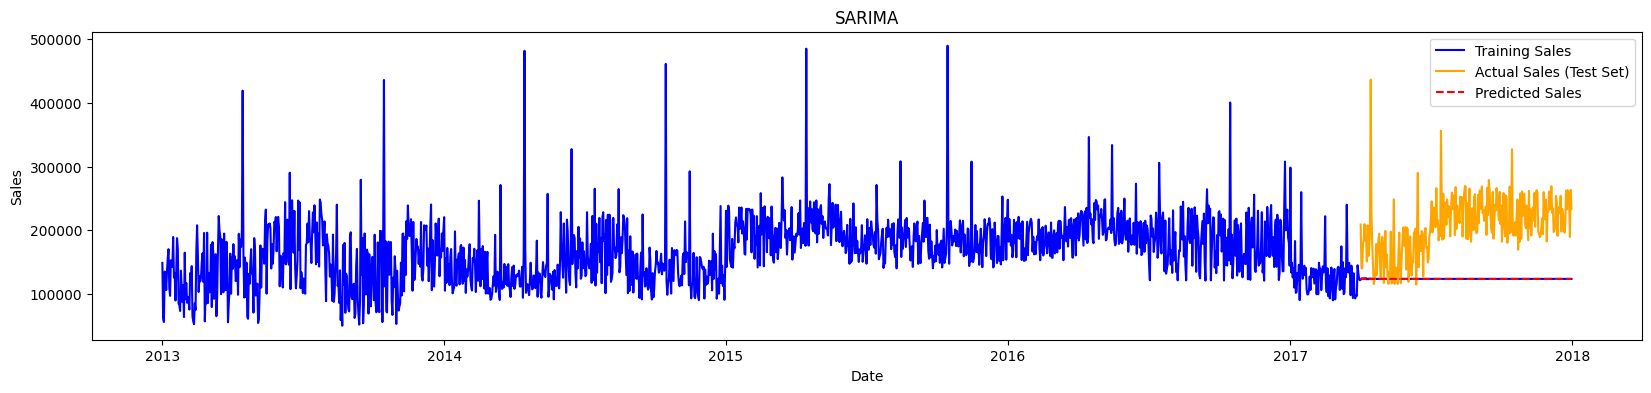

In [2]:
# Plot actual vs predicted sales
plt.figure(figsize=(20, 4))
plt.plot(train_data['sales'], label='Training Sales', color='blue')
plt.plot(test_data['sales'], label='Actual Sales (Test Set)', color='orange')
plt.plot(test_data.index, test_data['predicted_sales'], label='Predicted Sales', color='red', linestyle='--')
plt.title('SARIMA')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

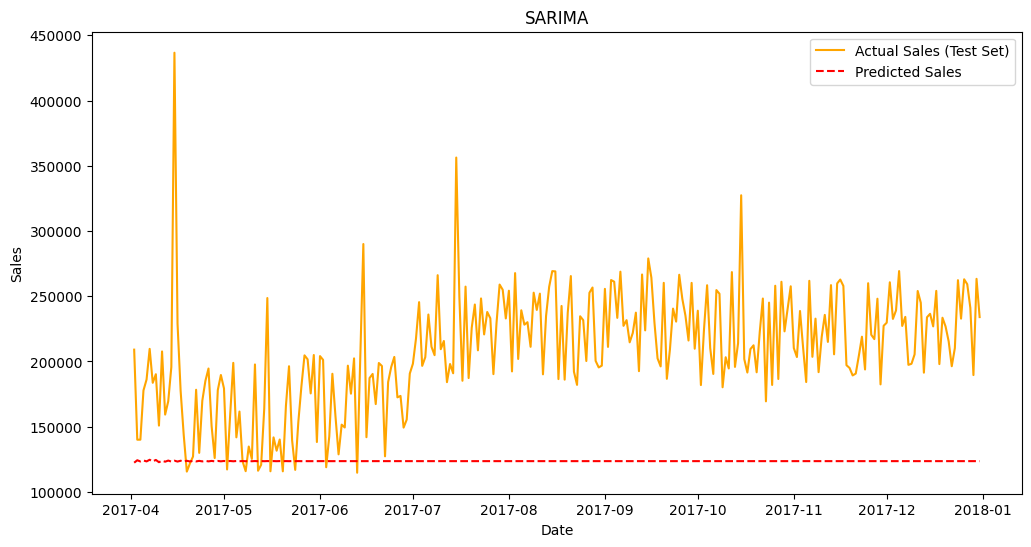

In [ ]:
# Plot actual vs predicted sales for the test set only
plt.figure(figsize=(12, 6))
plt.plot(test_data['sales'], label='Actual Sales (Test Set)', color='orange')
plt.plot(test_data.index, test_data['predicted_sales'], label='Predicted Sales', color='red', linestyle='--')
plt.title('SARIMA')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()
 